# Classifying Merging Galaxies

Our final project this year is based on the paper by Ćiprijanović et al (2021):

https://arxiv.org/pdf/2103.01373.pdf

You don't need to read the whole paper, and certainly don't need to understand all of it.  But we'll try to reproduce some of their work by implementing the final CNN architecture they developed and optimized in the paper.  The final architecture is described in Table A1 near the end of the paper.

The goal of the software is to identify when a pair of galaxies that look close to each other visually on the sky are actually merging versus when just passing near each other in projection.  (E.g. one may be more distant than the other, so they aren't actually that close to each other.) 

Merging galaxies are interesting! They develop two kinds of features: one due to tidal gravitational interactions, and the second (related) one due to the triggering of star formation. These features should not be present if it's a chance projection rather than a true merger.  Wikipedia (of course) has a nice [page](https://en.wikipedia.org/wiki/Galaxy_merger) about this with some pictures of mergers with these kinds of features.

The data we will be using here are simulated images from an N-body simulation called Illustris-1, and are designed to mimic what would be obtained from real observations with either the Hubble Space Telescope or the James Webb Space Telescope.  So, we have truth information in all cases to train and test the performance of the CNN.

### 1. Download the data

The researchers have made their data public on their [Deep Merge website](https://stdatu.stsci.edu/hlsp/deepmerge), so we can access them.  We'll use the 2-filter data sets (i.e. just the mock HST images).  And to make our lives a bit easier, we'll use the version without the extra instrumental noise added (which they call "pristine").

Download the following files:

https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-pristine-x.npy
https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-labels-y.npy

and save the downloaded files in the same directory as your notebook.

**Warning**: The image file is almost 2 GB.  Make sure you have at least this much space on your computer for this.

### 2. Load and visualize the data

The first thing to do with any data set is to look at it visually.  Load the data into variables:
* `X` holds the input data, which in this case are images of possibly merging galaxies.
* `y` holds the labels, which in this case are either 1 for mergers or 0 for non-mergers.

Write a script to show some smallish number of galaxies with figure titles indicating whether they are a merger or not.

In [1]:
import numpy as np

X = np.load('hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-pristine-x.npy')
y = np.load('hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-labels-y.npy')

print('X shape = ', X.shape)
print('y shape = ', y.shape)

# X.shape is (15426, 3, 75, 75)
# The first dimension is the total number of images we have.
# The second dimension is the filters.  These are like the RGB layers in a color image.
# The third and fourth dimensions are the image size 75x75 pixels.

# This shape is called "channel first" order. 
# It can work with keras if you are running on GPUs, but not on CPUs for some reason.
# So we need to switch to "channel last" order, since most of you will be running keras on CPUs.
X = np.moveaxis(X, 1, -1)
print('new X shape = ',X.shape)

X shape =  (15426, 3, 75, 75)
y shape =  (15426,)
new X shape =  (15426, 75, 75, 3)


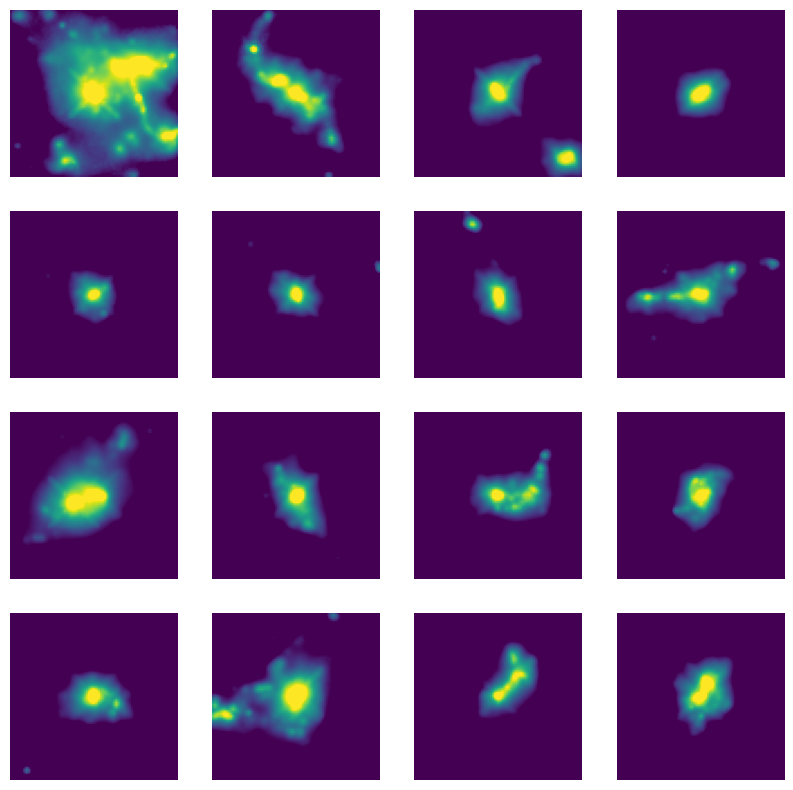

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import random

# Plot some of the images.

# Hints: 1. An array of 4x4 images looks pretty good here.  
#           Select 16 images at random and plot them
#        2. Select just one of the 3 filters (i.e. the last dimension of X).
#        3. The dynamic range in these images is pretty large, so they look better with log scaling.
#           Use imshow with norm=LogNorm(vmin=0.01, vmax=1).
#        4. If you want to see more of these, run this cell again, which should select a different
#           random sample of 16 images.  
#        5. You can also change your filter choice and rerun to see the differences in the different filters.
# YOUR CODE HERE

#randomly select 16 images
random_indices = random.sample(range(X.shape[0]), 16)
subset_images = X[random_indices, :, :, -1]

#plot each image, log scaling
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(subset_images[i], norm=LogNorm(vmin=0.01, vmax=1))
    ax.axis('off')
    
plt.show()

### 3. Divide data into training, validation, and testing sets

Divide the total data set into a training set, a validation set, and a test set with the following relative sizes:

* 70% Training
* 10% Validation
* 20% Testing

In [11]:
from sklearn.model_selection import train_test_split

# Split X and y into:
# X_train, y_train = training data and labels (70%)
# X_valid, y_valid = validation data and labels (10%)
# X_test, y_test = test data and labels (20%)

# Hints: You'll need to call this function twice to get 3 subsets.
#        Write some assert statements to confirm to yourself that you did the splitting right.

X_train, X_rest, Y_train, Y_rest = train_test_split(X, y, test_size = 0.3, random_state = 1234)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rest, Y_rest, test_size = float(2/3), random_state = 1234)

assert np.isclose(len(X_train)/len(X), 0.7, atol=0.01)
assert np.isclose(len(X_test)/len(X), 0.2, atol=0.01)
assert np.isclose(len(X_valid)/len(X), 0.1,atol=0.01)



### 4. Build a CNN

Build the cnn described in Table A1 of [the paper](https://arxiv.org/pdf/2103.01373.pdf).

In [30]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2


# Hints: 1. When they say Padding=1 or 2, use 'same'.  When Padding=0, use 'valid'.
#           I honestly don't know what the numbers are supposed to represent.
#        2. They end with a softmax output layer with two output channels, but it's a little 
#           simpler to have a single output channel with a sigmoid activation, so it
#           returns a single output value that can be considered a probability of the image
#           being a merger.
#        3. The table lists ReLU activation for the other two dense layers, but the code
#           in their repo uses Softmax.  I'm not sure if that's a typo that no one noticed
#           or what, but I found that Softmax works better for these.
#        4. They don't mention it in the table, but they also used an L2 regularizer
#           for the dense layers.  Use kernel_regularizer=l2(1.e-4) for the first two
#           dense layers.

# YOUR CODE HERE
cnn = Sequential()
cnn.add(Convolution2D(filters=8, 
                      kernel_size= (5,5),
                      padding='same',
                      activation='relu',
                      input_shape=(75,75,3)
                      ))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2),
                     strides=(2, 2),
                     padding='valid'))
cnn.add(Convolution2D(filters=16, 
                      kernel_size= (3,3),
                      padding='same',
                      activation='relu'
                      ))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2),
                     strides=(2, 2),
                     padding='valid'))
cnn.add(Convolution2D(filters=32, 
                      kernel_size= (2,2),
                      padding='same',
                      activation='relu'
                      ))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2),
                    strides=(2, 2),
                    padding='valid'))
cnn.add(Flatten())
cnn.add(Dense(64,
              activation='softmax',
              kernel_regularizer=l2(1.e-4)))
cnn.add(Dense(32,
              activation='softmax',
              kernel_regularizer=l2(1.e-4)))
cnn.add(Dense(1,
              activation='sigmoid'))

# Check the output shape and number of parameters for each layer, comparing
# your CNN to the one described in Table A1.
cnn.summary()

# Note: My version reported 2x the number of parameters for the BatchNormalization
#       layers than they wrote in the table.  I'm not sure why.

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 75, 75, 8)         608       
                                                                 
 batch_normalization_26 (Bat  (None, 75, 75, 8)        32        
 chNormalization)                                                
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 37, 37, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 37, 37, 16)        1168      
                                                                 
 batch_normalization_27 (Bat  (None, 37, 37, 16)       64        
 chNormalization)                                                
                                                     

In [33]:
from keras.optimizers import Adam

# Compile your CNN Model

# Hints: 1. Use the Adam optimizer with a learning rate of 0.001.
#        2. Use 'accuracy' for the fit metric
#        3. Use the 'binary_crossentropy' loss function.

# YOUR CODE HERE
cnn.compile(optimizer=Adam(learning_rate=1e-3),
            loss= 'binary_crossentropy',
            metrics=['accuracy'])

In [34]:
# This is the same Callback we gave you in HW7:

# This cell contains a class designed to give you some visual feedback as to how the
# NN training is going.  It is something called a Callback in keras, and it can help
# you see what is going on during the training.

# Basically, after each training cycle, keras will call the on_epoch_end() function here,
# which will make a plot showing the progress so far and display it on the screen.
# There is nothing for you to do here.  Feel free to skip over it if you want, but
# it might be interesting for you to try to understand how it works in case you ever
# want to write something similar for yourself.  (Or modify this one.)

import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.callbacks import Callback

class PlotLosses(Callback):
    def __init__(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        fig, axes = plt.subplots(1,2,figsize=(8,3))
        
        axes[0].plot(self.x, self.losses, label="Train loss")
        axes[0].plot(self.x, self.val_losses, label="Validation loss")
        axes[0].set_yscale('log')
        axes[0].set_xlabel('Number of epochs')
        axes[0].set_ylabel('Losses')
        axes[0].legend()
            
        axes[1].plot(self.x, self.acc, label="Train accuracy")
        axes[1].plot(self.x, self.val_acc, label="Validation accuracy")
        axes[1].set_xlabel('Number of epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()

In [36]:
from keras.models import load_model

# Train the model
# This is pretty time consuming, and the TA's won't want to run this themselves.
# So after fitting, we will save the fitted model to a file.
# Once you are happy with the training, change the "if True" to "if False" 
# so subsequent runs will skip the training and just load your saved file.
# This is how the TAs will run your notebook.
# Don't forget to submit the file with the saved model along with your notebook.

# Change YOUR_NAME to your actual name (username or whatever -- something unique to you)
save_file_name = "janumolu_fitted_model.keras"

if True:
    # Hints: 1. One thing you can adjust here is the batch size.  Try to figure out a good 
    #           value for that.  There may be other options worth adjusting.  Read the docs
    #           for the fit function to see what else might be worth trying here.
    #        2. You'll probably need rather a lot of epochs of training.  If it doesn't seem
    #           to have converged, you can run this cell again to continue where you left off.
    
    # YOUR CODE HERE
    cnn.fit(x=X_train, y=Y_train, batch_size=10000, epochs=20, callbacks=[PlotLosses()])
    
    cnn.save(save_file_name)
    
cnn = load_model(save_file_name)

Epoch 1/20


KeyboardInterrupt: 

### 5. Predict mergers

Now use the trained CNN to predict mergers in the test data.

Plot the confusion matrix and ROC curve.

In [ ]:
y_pred = cnn.predict(X_test).T[0]

print('Predictions: ',y_pred)
print('Truth: ',y_test)

In [ ]:
from sklearn.metrics import confusion_matrix

# Make a plot of the confusion matrix, assuming a threshold of p=0.5.

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
from sklearn.metrics import roc_curve

# Make a plot of the ROC curve

# YOUR CODE HERE
raise NotImplementedError()

### 6. Look at some of the failures.

Take a look as some of the images that were mis-classified.  Comment on why you think these might have been harder than other images to get right.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Comments on the above:

YOUR ANSWER HERE

### 7. Going further

The CNN that we built here seems pretty prone to overfitting.  The paper describes some of the ways the authors tried to mitigate that.  We've also learned some techniques for that in class.  Try a couple adjustments to the architecture above to see if you can get better results.

Describe some of the things you tried.  What worked?  What didn't?  What might you have wanted to try but didn't have time or resources for?

YOUR ANSWER HERE